In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input,Dense,Embedding,LSTM,Dropout
from keras.layers.merge import add

Using TensorFlow backend.


<h1>Read Captions File</h1>

In [2]:
# pip uninstall nltk

# pip install -U nltk

In [3]:
with open("./FLICKR8K/Flickr_Data/Flickr_TextData/Flickr8k.token.txt",encoding ="utf-8 ") as f:
    captions = f.read()
    f.close()

In [4]:
captions = captions.split("\n")[:-1]

In [5]:
captions

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a pai

In [6]:
len(captions)

40460

# creating a "descriptions" dictionary  where key is 'img_name' and value is list of captions corresponding to that image_file

In [7]:
descriptions = {}

for ele in captions:
    i_to_c = ele.split("\t")
    img_name = i_to_c[0].split(".")[0]
    caption = i_to_c[1]
    
    #if key is not present, initialise it with empty list.
    if descriptions.get(img_name) == None:
        descriptions[img_name] = []
    descriptions[img_name].append(caption)

In [8]:
descriptions

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

In [9]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

# Data Cleaning

1. lower each word
2. remove puntuations
3. remove words less than length 2

In [10]:
def clean_data(sample):
    sample = sample.lower()
    
    sample = re.sub("[^a-z]+"," ",sample)
    
    sample = sample.split()
    
    sample = [s for s in sample if len(s)>1]
    
    sample = " ".join(sample)
    
    return sample

In [11]:
clean_data("My noghsujf si am m cricket101 &8 mphi*&86%%&??,BY6fajdn 213 q rqu243 boy  32 ewr wO>>J DHD 34  asfb HHGY Gvg HgB   231 123")

'my noghsujf si am cricket mphi by fajdn rqu boy ewr wo dhd asfb hhgy gvg hgb'

# Modify All The Captions

In [12]:
for key,desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_data(desc_list[i])

In [13]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

# Writing Clean Descriptions(Captions) To .txt File

In [14]:
f = open("caption.txt","w")
f.write(str(descriptions))
f.close()

In [15]:
##############
# Dont' run this cell
#############

#  reading description file





# f = open("caption.txt", 'r')
# descriptions = f.read()
# f.close()

# json_acceptable_string = descriptions.replace("'", "\"")
# descriptions = json.loads(json_acceptable_string)

# Creating The Unique Vocabulary (Total NO Of Unique Words in entire Dataset)

In [16]:
vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]
print("Vocabulary Size %d" % len(vocabulary))

Vocabulary Size 8424


In [17]:
vocabulary

{'struggling',
 'gold',
 'snowmobiles',
 'paint',
 'bend',
 'playgroud',
 'utility',
 'winner',
 'housing',
 'skipped',
 'killer',
 'hissing',
 'couches',
 'sight',
 'photographs',
 'steap',
 'hilltops',
 'flamboyant',
 'actions',
 'boatload',
 'unmanned',
 'pnc',
 'barrier',
 'bridesmaids',
 'featuring',
 'fear',
 'guidewire',
 'christmas',
 'makeshift',
 'lines',
 'skateboarding',
 'bout',
 'grand',
 'obedience',
 'torch',
 'gentle',
 'radio',
 'gentleman',
 'truck',
 'creating',
 'wipeout',
 'aerodynamically',
 'knocking',
 'laptop',
 'sculpture',
 'laps',
 'trousers',
 'retreiver',
 'clap',
 'vest',
 'lets',
 'exploring',
 'medieval',
 'sparsely',
 'bolts',
 'boatful',
 'clasped',
 'stares',
 'tongee',
 'tells',
 'an',
 'quarter',
 'ticket',
 'biohazard',
 'impeach',
 'quarry',
 'teaching',
 'od',
 'rollercoaster',
 'bracelets',
 'nothing',
 'brochure',
 'striped',
 'ladles',
 'canon',
 'conoes',
 'dirtbed',
 'shadow',
 'lecturer',
 'gated',
 'solid',
 'wood',
 'kites',
 'picutre',

# All Words In description Dictionary

In [18]:
all_vocab = []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]
print("All Vocabulary Size %d" % len(all_vocab))

All Vocabulary Size 373837


In [19]:
all_vocab

['child',
 'in',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way',
 'girl',
 'going',
 'into',
 'wooden',
 'building',
 'little',
 'girl',
 'climbing',
 'into',
 'wooden',
 'playhouse',
 'little',
 'girl',
 'climbing',
 'the',
 'stairs',
 'to',
 'her',
 'playhouse',
 'little',
 'girl',
 'in',
 'pink',
 'dress',
 'going',
 'into',
 'wooden',
 'cabin',
 'black',
 'dog',
 'and',
 'spotted',
 'dog',
 'are',
 'fighting',
 'black',
 'dog',
 'and',
 'tri',
 'colored',
 'dog',
 'playing',
 'with',
 'each',
 'other',
 'on',
 'the',
 'road',
 'black',
 'dog',
 'and',
 'white',
 'dog',
 'with',
 'brown',
 'spots',
 'are',
 'staring',
 'at',
 'each',
 'other',
 'in',
 'the',
 'street',
 'two',
 'dogs',
 'of',
 'different',
 'breeds',
 'looking',
 'at',
 'each',
 'other',
 'on',
 'the',
 'road',
 'two',
 'dogs',
 'on',
 'pavement',
 'moving',
 'toward',
 'each',
 'other',
 'little',
 'girl',
 'covered',
 'in',
 'paint',
 'sits',
 'in',
 'front',

## Now we want to set threshold on the words because during the process of finding the captions while predicting next word in caption it has to look after so many words which is not a good thing so what we are doing is set a threshold that all the words which are ocuuring less than thresold frequency are been discarded

# count the frequency of each word, sort them and discard the words having frequency lesser than threshold value

In [20]:
import collections

## Bhaiya's Method

In [21]:
counter = collections.Counter(all_vocab)

dic_ = dict(counter)

threshold_value = 10

sorted_dic = sorted(dic_.items(),reverse=True,key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshold_value]
all_vocab = [x[0] for x in sorted_dic]


In [22]:
counter

Counter({'child': 1545,
         'in': 18987,
         'pink': 739,
         'dress': 348,
         'is': 9345,
         'climbing': 507,
         'up': 1302,
         'set': 109,
         'of': 6723,
         'stairs': 109,
         'an': 2432,
         'entry': 1,
         'way': 53,
         'girl': 3328,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 511,
         'little': 1768,
         'playhouse': 6,
         'the': 18420,
         'to': 3176,
         'her': 1178,
         'cabin': 4,
         'black': 3848,
         'dog': 8138,
         'and': 8863,
         'spotted': 38,
         'are': 3505,
         'fighting': 133,
         'tri': 14,
         'colored': 221,
         'playing': 2008,
         'with': 7765,
         'each': 430,
         'other': 773,
         'on': 10746,
         'road': 398,
         'white': 3959,
         'brown': 2578,
         'spots': 29,
         'staring': 57,
         'at': 2916,
         'street': 

In [23]:
len(all_vocab)

1845

In [24]:
all_vocab

['in',
 'the',
 'on',
 'is',
 'and',
 'dog',
 'with',
 'man',
 'of',
 'two',
 'white',
 'black',
 'boy',
 'are',
 'woman',
 'girl',
 'to',
 'wearing',
 'at',
 'people',
 'water',
 'red',
 'young',
 'brown',
 'an',
 'his',
 'blue',
 'dogs',
 'running',
 'through',
 'playing',
 'while',
 'shirt',
 'down',
 'standing',
 'ball',
 'little',
 'grass',
 'snow',
 'child',
 'person',
 'jumping',
 'over',
 'three',
 'front',
 'sitting',
 'holding',
 'up',
 'field',
 'small',
 'by',
 'large',
 'green',
 'one',
 'group',
 'yellow',
 'her',
 'walking',
 'children',
 'men',
 'into',
 'air',
 'beach',
 'near',
 'mouth',
 'jumps',
 'another',
 'for',
 'street',
 'runs',
 'its',
 'from',
 'riding',
 'stands',
 'as',
 'bike',
 'girls',
 'outside',
 'other',
 'off',
 'out',
 'rock',
 'next',
 'play',
 'orange',
 'looking',
 'pink',
 'player',
 'camera',
 'their',
 'pool',
 'hat',
 'jacket',
 'boys',
 'women',
 'around',
 'behind',
 'some',
 'background',
 'dirt',
 'toy',
 'soccer',
 'sits',
 'dressed',
 

## My Method


# Loading Training & Testing Dataset

In [25]:
# Train Images

f = open("./FLICKR8K/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt",encoding ="utf-8 ")
train = f.read()
f.close()

In [26]:
train = [e.split(".")[0] for e in train.split("\n")[:-1]]

In [27]:
train

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079',
 '2699342860_5288e203ea',
 '2638369467_8fc251595b',
 '2926786902_815a99a154',
 '2851304910_b5721199bc',
 '3423802527_94bd2b23b0',
 '3356369156_074750c6cc',
 '2294598473_40637b5c04',
 '1191338263_a4fa073154',
 '2380765956_6313d8cae3',
 '3197891333_b1b0fd1702',
 '3119887967_271a097464',
 '2276499757_b44dc6f8ce',
 '2506892928_7e79bec613',
 '2187222896_c206d63396',
 '2826769554_85c90864c9',
 '3097196395_ec06075389',
 '3603116579_4a28a932e2',
 '3339263085_6db9fd0981',
 '2532262109_87429a2cae',
 '2076906555_c20dc082db',
 '2502007071_82a8c639cf',
 '3113769557_9edbb8275c',
 '3325974730_3ee192e4ff',
 '1655781989_b15ab4cbff',
 '1662261486_db967930de',
 '2410562803_56ec09f41c',
 '2469498117_b4543e1460',
 '69710415_5c2bfb1058',
 '3414734842_beb543f400',
 '3006217970_90b42e6b27',
 '2192411521_9c7e488c5e',
 '3535879138_928

In [28]:
len(train)

6000

In [29]:
# Test Images

f = open("./FLICKR8K/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt",encoding ="utf-8 ")
test = f.read()
f.close()

In [30]:
test  = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [31]:
len(test)

1000

## Adding Startseq & end seq in all training caption so that model will know where to start the caption and where to end it

## Create dictionary for the caption of  train images by using previous ductionary which contain all the images

In [32]:
train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq" + cap + "endseq"
        train_descriptions[t].append(cap_to_append)

In [33]:
len(train_descriptions)

6000

In [34]:
train_descriptions

{'2513260012_03d33305cf': ['startseqblack dog is running after white dog in the snowendseq',
  'startseqblack dog chasing brown dog through snowendseq',
  'startseqtwo dogs chase each other across the snowy groundendseq',
  'startseqtwo dogs play together in the snowendseq',
  'startseqtwo dogs running through low lying body of waterendseq'],
 '2903617548_d3e38d7f88': ['startseqlittle baby plays croquetendseq',
  'startseqlittle girl plays croquet next to truckendseq',
  'startseqthe child is playing croquette by the truckendseq',
  'startseqthe kid is in front of car with put and ballendseq',
  'startseqthe little boy is playing with croquet hammer and ball beside the carendseq'],
 '3338291921_fe7ae0c8f8': ['startseqbrown dog in the snow has something hot pink in its mouthendseq',
  'startseqbrown dog in the snow holding pink hatendseq',
  'startseqbrown dog is holding pink shirt in the snowendseq',
  'startseqdog is carrying something pink in its mouth while walking through the snowe

# Data Preprocessing - Images

## we will end the resnet layer at 2048 which is the thrd last layer of renet and add it to 26 units of network we are doing this so that it will learn better embedding

## So in this section we will load our image and do some preprocessing

In [35]:
model = ResNet50(weights = "imagenet",input_shape = (224,224,3))

In [36]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [37]:
my_model = Model(model.input,model.layers[-2].output)

In [38]:
my_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [39]:
images = "./FLICKR8K/Flickr_Data/Images"

In [40]:
def preprocess_image(img):
    img = image.load_img(img,target_size = (224,224))
    img = image.img_to_array(img)
#     img = np.expand_dims(img,axis=0)
    img = img.reshape(1,224,224,3)
    img = preprocess_input(img)
    return img

In [41]:
def encode_image(img):
    img = preprocess_image(img)#calling above function
    feature_vector = my_model.predict(img)#(2048,1) return karega
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

## Here the idea is to get emedding for all training images and setting it equal to the actual image name

# Here what we are doing in encoding_train[img[len(images):]] this is it also contain name of other fladers in which the image is put in but we want name of only image so we use this to select name of the image and against name we are putting the encoding of 048 for the image

In [42]:
#Test Image
start = time()
encoding_train = {}
for ix,img in enumerate(train):
    img = "./FLICKR8K/Flickr_Data/Images/{}.jpg".format(train[ix])
    encoding_train[img[len(images):]] = encode_image(img)
    
    if ix%100 == 0:
        print("Encoding image-"+str(ix))
print("Time taken in seconds = ",time()-start)

Encoding image-0
Encoding image-100
Encoding image-200
Encoding image-300
Encoding image-400
Encoding image-500
Encoding image-600
Encoding image-700
Encoding image-800
Encoding image-900
Encoding image-1000
Encoding image-1100
Encoding image-1200
Encoding image-1300
Encoding image-1400
Encoding image-1500
Encoding image-1600
Encoding image-1700
Encoding image-1800
Encoding image-1900
Encoding image-2000
Encoding image-2100
Encoding image-2200
Encoding image-2300
Encoding image-2400
Encoding image-2500
Encoding image-2600
Encoding image-2700
Encoding image-2800
Encoding image-2900
Encoding image-3000
Encoding image-3100
Encoding image-3200
Encoding image-3300
Encoding image-3400
Encoding image-3500
Encoding image-3600
Encoding image-3700
Encoding image-3800
Encoding image-3900
Encoding image-4000
Encoding image-4100
Encoding image-4200
Encoding image-4300
Encoding image-4400
Encoding image-4500
Encoding image-4600
Encoding image-4700
Encoding image-4800
Encoding image-4900
Encoding ima

In [43]:
len(encoding_train)

6000

In [44]:
encoding_train

{'/2513260012_03d33305cf.jpg': array([0.28047314, 0.40687397, 0.08379973, ..., 0.9107919 , 0.04341817,
        0.09577907], dtype=float32),
 '/2903617548_d3e38d7f88.jpg': array([0.        , 0.00244133, 0.07775952, ..., 0.32224596, 0.3387253 ,
        0.82698166], dtype=float32),
 '/3338291921_fe7ae0c8f8.jpg': array([0.649989  , 0.45327228, 0.35990572, ..., 0.01184076, 0.17420328,
        0.04910804], dtype=float32),
 '/488416045_1c6d903fe0.jpg': array([0.59114206, 0.24315473, 0.        , ..., 1.1071404 , 0.44211772,
        0.4111294 ], dtype=float32),
 '/2644326817_8f45080b87.jpg': array([0.08373525, 0.55374795, 0.0366526 , ..., 0.11103816, 1.0484875 ,
        0.        ], dtype=float32),
 '/218342358_1755a9cce1.jpg': array([1.5750597 , 0.3306421 , 0.34105465, ..., 0.24407965, 0.03760226,
        0.03851034], dtype=float32),
 '/2501968935_02f2cd8079.jpg': array([0.08495866, 1.2882224 , 0.03415347, ..., 0.1563588 , 0.5512882 ,
        1.3358809 ], dtype=float32),
 '/2699342860_5288e203

In [45]:
len(images)

29

In [46]:
img[len(images):]

'/2671602981_4edde92658.jpg'

## Now We have to save these train embedding files

In [47]:
with open("./encoded_train_images.pkl","wb") as encoded_pickle:
    pickle.dump(encoding_train,encoded_pickle)

In [48]:
#Test Image

start = time()
encoding_test = {}
for ix,img in enumerate(test):
    img = "./FLICKR8K/Flickr_Data/Images/{}.jpg".format(test[ix])
    encoding_test[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding Image:- " + str(ix))
print("Time taken in seconds:-",time()-start)

Encoding Image:- 0
Encoding Image:- 100
Encoding Image:- 200
Encoding Image:- 300
Encoding Image:- 400
Encoding Image:- 500
Encoding Image:- 600
Encoding Image:- 700
Encoding Image:- 800
Encoding Image:- 900
Time taken in seconds:- 224.9445297718048


In [49]:
with open("./encoded_test_images.pkl","wb") as encoded_pickle:
    pickle.dump(encoding_test,encoded_pickle)

## Now Loading train & test embedding

In [50]:
# with open("./encoded_train_images.pkl", "rb") as encoded_pickle:
#     encoding_train = pickle.load(encoded_pickle)

In [51]:
# encoding_train['2513260012_03d33305cf.jpg'].shape

In [52]:
# with open("./encoded_test_images.pkl", "rb") as encoded_pickle:
#     encoding_test = pickle.load(encoded_pickle)

In [53]:
# encoding_test['3385593926_d3e9c21170.jpg'].shape

# Mapping all the words of all_vocab with number

In [36]:
len(all_vocab)

1845

In [37]:
ix=1
word_to_idx = {}
idx_to_word = {}
for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix += 1

In [38]:
#  need to add these 2 words as well (explicitly)
 
word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [39]:
#  vocab_size is total vocabulary len +1 because we will append 0's as well. 

vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


# Max Length kitni h sakti hai caption ki

In [68]:
all_caption_len = []
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_caption_len.append(len(cap.split()))
max_len = max(all_caption_len)
print(max_len)

33


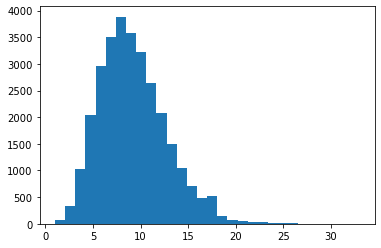

In [69]:
a=plt.hist(all_caption_len, bins=30)

In [40]:
idx_to_word

{1: 'in',
 2: 'the',
 3: 'on',
 4: 'is',
 5: 'and',
 6: 'dog',
 7: 'with',
 8: 'man',
 9: 'of',
 10: 'two',
 11: 'white',
 12: 'black',
 13: 'boy',
 14: 'are',
 15: 'woman',
 16: 'girl',
 17: 'to',
 18: 'wearing',
 19: 'at',
 20: 'people',
 21: 'water',
 22: 'red',
 23: 'young',
 24: 'brown',
 25: 'an',
 26: 'his',
 27: 'blue',
 28: 'dogs',
 29: 'running',
 30: 'through',
 31: 'playing',
 32: 'while',
 33: 'shirt',
 34: 'down',
 35: 'standing',
 36: 'ball',
 37: 'little',
 38: 'grass',
 39: 'snow',
 40: 'child',
 41: 'person',
 42: 'jumping',
 43: 'over',
 44: 'three',
 45: 'front',
 46: 'sitting',
 47: 'holding',
 48: 'up',
 49: 'field',
 50: 'small',
 51: 'by',
 52: 'large',
 53: 'green',
 54: 'one',
 55: 'group',
 56: 'yellow',
 57: 'her',
 58: 'walking',
 59: 'children',
 60: 'men',
 61: 'into',
 62: 'air',
 63: 'beach',
 64: 'near',
 65: 'mouth',
 66: 'jumps',
 67: 'another',
 68: 'for',
 69: 'street',
 70: 'runs',
 71: 'its',
 72: 'from',
 73: 'riding',
 74: 'stands',
 75: 'as',


In [71]:
vocab_size

1848

In [41]:
word_to_idx

{'in': 1,
 'the': 2,
 'on': 3,
 'is': 4,
 'and': 5,
 'dog': 6,
 'with': 7,
 'man': 8,
 'of': 9,
 'two': 10,
 'white': 11,
 'black': 12,
 'boy': 13,
 'are': 14,
 'woman': 15,
 'girl': 16,
 'to': 17,
 'wearing': 18,
 'at': 19,
 'people': 20,
 'water': 21,
 'red': 22,
 'young': 23,
 'brown': 24,
 'an': 25,
 'his': 26,
 'blue': 27,
 'dogs': 28,
 'running': 29,
 'through': 30,
 'playing': 31,
 'while': 32,
 'shirt': 33,
 'down': 34,
 'standing': 35,
 'ball': 36,
 'little': 37,
 'grass': 38,
 'snow': 39,
 'child': 40,
 'person': 41,
 'jumping': 42,
 'over': 43,
 'three': 44,
 'front': 45,
 'sitting': 46,
 'holding': 47,
 'up': 48,
 'field': 49,
 'small': 50,
 'by': 51,
 'large': 52,
 'green': 53,
 'one': 54,
 'group': 55,
 'yellow': 56,
 'her': 57,
 'walking': 58,
 'children': 59,
 'men': 60,
 'into': 61,
 'air': 62,
 'beach': 63,
 'near': 64,
 'mouth': 65,
 'jumps': 66,
 'another': 67,
 'for': 68,
 'street': 69,
 'runs': 70,
 'its': 71,
 'from': 72,
 'riding': 73,
 'stands': 74,
 'as': 75,


In [42]:
with open("./word_to_idx.pkl","wb") as w2i_pickle:
    pickle.dump(word_to_idx,w2i_pickle)

In [43]:
with open("./idx_to_word.pkl","wb") as i2w_pickle:
    pickle.dump(idx_to_word,i2w_pickle)

# Data Preparation Using Generator Function(Supervised Learning)


### 1) What we are doing here is passing image and partial caption untill the point we encounter "endsequence" and we are doing this for all 5 caption of that particular image

### 2) After that we will convert words to numbers or we say maping and add padding to every partial caption

### For more see note book and Blog

In [73]:
train_descriptions

{'2513260012_03d33305cf': ['startseqblack dog is running after white dog in the snowendseq',
  'startseqblack dog chasing brown dog through snowendseq',
  'startseqtwo dogs chase each other across the snowy groundendseq',
  'startseqtwo dogs play together in the snowendseq',
  'startseqtwo dogs running through low lying body of waterendseq'],
 '2903617548_d3e38d7f88': ['startseqlittle baby plays croquetendseq',
  'startseqlittle girl plays croquet next to truckendseq',
  'startseqthe child is playing croquette by the truckendseq',
  'startseqthe kid is in front of car with put and ballendseq',
  'startseqthe little boy is playing with croquet hammer and ball beside the carendseq'],
 '3338291921_fe7ae0c8f8': ['startseqbrown dog in the snow has something hot pink in its mouthendseq',
  'startseqbrown dog in the snow holding pink hatendseq',
  'startseqbrown dog is holding pink shirt in the snowendseq',
  'startseqdog is carrying something pink in its mouth while walking through the snowe

In [74]:
encoding_train

{'/2513260012_03d33305cf.jpg': array([0.28047314, 0.40687397, 0.08379973, ..., 0.9107919 , 0.04341817,
        0.09577907], dtype=float32),
 '/2903617548_d3e38d7f88.jpg': array([0.        , 0.00244133, 0.07775952, ..., 0.32224596, 0.3387253 ,
        0.82698166], dtype=float32),
 '/3338291921_fe7ae0c8f8.jpg': array([0.649989  , 0.45327228, 0.35990572, ..., 0.01184076, 0.17420328,
        0.04910804], dtype=float32),
 '/488416045_1c6d903fe0.jpg': array([0.59114206, 0.24315473, 0.        , ..., 1.1071404 , 0.44211772,
        0.4111294 ], dtype=float32),
 '/2644326817_8f45080b87.jpg': array([0.08373525, 0.55374795, 0.0366526 , ..., 0.11103816, 1.0484875 ,
        0.        ], dtype=float32),
 '/218342358_1755a9cce1.jpg': array([1.5750597 , 0.3306421 , 0.34105465, ..., 0.24407965, 0.03760226,
        0.03851034], dtype=float32),
 '/2501968935_02f2cd8079.jpg': array([0.08495866, 1.2882224 , 0.03415347, ..., 0.1563588 , 0.5512882 ,
        1.3358809 ], dtype=float32),
 '/2699342860_5288e203

In [75]:
word_to_idx

{'in': 1,
 'the': 2,
 'on': 3,
 'is': 4,
 'and': 5,
 'dog': 6,
 'with': 7,
 'man': 8,
 'of': 9,
 'two': 10,
 'white': 11,
 'black': 12,
 'boy': 13,
 'are': 14,
 'woman': 15,
 'girl': 16,
 'to': 17,
 'wearing': 18,
 'at': 19,
 'people': 20,
 'water': 21,
 'red': 22,
 'young': 23,
 'brown': 24,
 'an': 25,
 'his': 26,
 'blue': 27,
 'dogs': 28,
 'running': 29,
 'through': 30,
 'playing': 31,
 'while': 32,
 'shirt': 33,
 'down': 34,
 'standing': 35,
 'ball': 36,
 'little': 37,
 'grass': 38,
 'snow': 39,
 'child': 40,
 'person': 41,
 'jumping': 42,
 'over': 43,
 'three': 44,
 'front': 45,
 'sitting': 46,
 'holding': 47,
 'up': 48,
 'field': 49,
 'small': 50,
 'by': 51,
 'large': 52,
 'green': 53,
 'one': 54,
 'group': 55,
 'yellow': 56,
 'her': 57,
 'walking': 58,
 'children': 59,
 'men': 60,
 'into': 61,
 'air': 62,
 'beach': 63,
 'near': 64,
 'mouth': 65,
 'jumps': 66,
 'another': 67,
 'for': 68,
 'street': 69,
 'runs': 70,
 'its': 71,
 'from': 72,
 'riding': 73,
 'stands': 74,
 'as': 75,


In [76]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,num_photos_per_batch):
    x1,x2,y = [], [], []
    #x1:- Image Encoding
    #x2:- Partial Captions
    #y:- Predicting Captions
    n=0
    while True:
        #Because Continuously generate data
        for key,desc_list in train_descriptions.items():
            n+=1
            #This will contain 2048 encoding
            photo_encoding = encoding_train["/"+key+".jpg"]
            #Now here we are first iterating over all 5 caption and than among it iterate over all words
            for desc in desc_list:
                #Here we are iterating over all the words of that particular sentence
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    #Now here we are spliting the data in set of partial caption and predicting word
                    in_seq = seq[0:i]
                    out_seq = seq[i]
                    
                    #Now here we are converting the partial caption into the padding sequence
                    in_seq = pad_sequences([in_seq],maxlen=max_len,value=0,padding="post")[0]
                    
                    #Now the output sequence must be vector of 1848 and among which all values will be 0 
                    #except for 1 which is 
                    #the index of that word
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    
                    x1.append(photo_encoding)
                    x2.append(in_seq)
                    y.append(out_seq)
                    
                    #This Process goes on till the point the batch size of the images get complete
                    #and after that we will yield the data which is similar to the return function
                    #the only difference it has is that it is a genrator function so it will help to
                    #load data again and again that will help to not put too much load on RAM
            if n==num_photos_per_batch:
                yield[[np.array(x1),np.array(x2)],np.array(y)]
                x1,x2,y = [],[],[]
                n=0

# Word Embedding

In [77]:
f = open("./GLOVE/glove.6B.50d.txt",encoding="utf-8")

In [78]:
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype="float")
    
    embedding_index[word] = coefs
f.close()

In [79]:
def get_embedding_output():
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
    return embedding_output
embedding_output = get_embedding_output()

In [80]:
embedding_output.shape

(1848, 50)

In [81]:
embedding_output

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.33042 ,  0.24995 , -0.60874 , ..., -0.50703 , -0.027273,
        -0.53285 ],
       [ 0.418   ,  0.24968 , -0.41242 , ..., -0.18411 , -0.11514 ,
        -0.78581 ],
       ...,
       [-0.34126 , -0.06117 ,  0.93339 , ..., -0.5682  , -0.6244  ,
         0.30874 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

# Model Architecture

# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Parital Caption ----->RNN------------>\
#                                             \ 
###                               Feed Forward Network  Ending With Softmax------>Predicted Word For The Further Sequence
#                              /
#                             /
#                            /
### Image Vector -------> /

## one layer contain 2048 vector of image which are learned by Resnet50 and than convert it into 256
## Than there is another layer which contain sentece of length 33 than we use RNN and than they are gonna convert each word into 50 embedding than use LSTM layer to convert it into 256 units than 
## Combine These two layer and generate single layer

In [82]:
#Image Feature Extracter Model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256,activation="relu")(inp_img1)

In [83]:
#Partial Caption sequence Model
#max_len=33
input_cap = Input(shape=(max_len,))
# This Embedding layer is going false because we have already learned it from GLOVE
#vocab_size=1848
inp_cap1 = Embedding(input_dim = vocab_size,output_dim=50,mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [84]:
#Adding those 2 layers here
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation="relu")(decoder1)
outputs = Dense(vocab_size,activation="softmax")(decoder2)

# Merge two networks
model = Model(inputs=[input_img_fea,input_cap],outputs=outputs)

In [85]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 33, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

## Now understand it in that way jab ham twitter emoji wala challenge kar rhe the tab wha ham ek sentence lete the jab ham wha x_train aur x_test bhejte the fir wo wha pe train_embedding aur test_embedding create kar deeta tha ham waisa hi kuch yha pe bhi kar sakte hai li har 8000 image ke per image 5 captions ko bhejo aur fir wo har ek word ko 50 ki embdding me convert kar dega par yhi par ek point ata hai ki ham yha hamare most important words ko hi use karke model ko train karenge jo ki hamne word_to_idx me store kiye hai tho uske liye ab hamne wha word_to_idx ke har ek word ke liye hamne jo number decide kiya tha usse  us word ke corresponding  embedding de di ab hamne embedding learn kar li hai tho hamara next kam hoga model ko create karna aur train karna tho uske liye hamne kya kia ki hamne kah yar aisa karo ek embedding layer create kar di jiske weights tho GLOVE ke hi honge par use ham encoding_train ke sath karenge jo ki (1848,50) hai ab yha se age kya hoga ki wo in 1848 ke basis pe prediction deta jayega ki next word kya hoga

In [86]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [87]:
model.compile(loss="categorical_crossentropy",optimizer="adam")

In [88]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [89]:
for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,number_pics_per_batch)
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save("./model_weights/model"+ str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 482s 241ms/step - loss: 4.6692
Epoch 1/1
2000/2000 [==============================] - 465s 233ms/step - loss: 3.9204
Epoch 1/1
2000/2000 [==============================] - 455s 228ms/step - loss: 3.6421
Epoch 1/1
2000/2000 [==============================] - 470s 235ms/step - loss: 3.4623
Epoch 1/1
2000/2000 [==============================] - 465s 232ms/step - loss: 3.3313
Epoch 1/1
2000/2000 [==============================] - 464s 232ms/step - loss: 3.2222
Epoch 1/1
2000/2000 [==============================] - 855s 428ms/step - loss: 3.1335
Epoch 1/1
2000/2000 [==============================] - 465s 233ms/step - loss: 3.0610
Epoch 1/1
2000/2000 [==============================] - 448s 224ms/step - loss: 3.0006
Epoch 1/1
2000/2000 [==============================] - 354s 177ms/step - loss: 2.9465


In [90]:
# model = load_model("./model_weights/model_9.h5")

# Prediction

In [91]:
# we are gonna serve it a image of 2048 embedding because if we are gonna send it a image of shape 224,224,3 model baukhla
# jayega
def predict_caption(photo):
    #it is the first word on the basis of this it is going to create the next word
    in_text = "startseq"
    # we are gonna run the loop to max_len=33 becoz we want it to generate sentence that is of maximum 35 length
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        # now after getting those numbers of the words of the generated sentence we are gonna make it of length 33 by padding
        sequence = pad_sequences([sequence] ,maxlen = max_len,padding="post")
        
        y_pred = model.predict([photo,sequence])
        y_pred = y_pred.argmax()
        word = idx_to_word[y_pred]
        in_text+=" "+word
        
        if word=="endseq":
            break
            
    final_caption = in_text.split()
    # For removing start and end sequence
    final_caption = final_caption[1:-1]
    final_caption = " ".join(final_caption)
    
    return final_caption

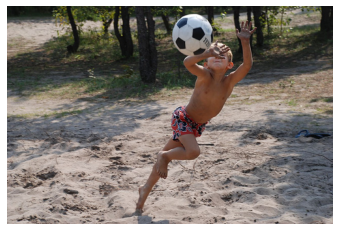

0
32
the ground whilst she climbs up to throw the ground for the ground as he walks on the ground with his dog on his head and his owner attached to the ground


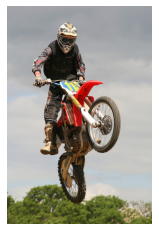

1
32
his bike on the dirt bike on the dirt bike on the dirt in the air as he rides his bike on the dirt in the air on the dirt in the


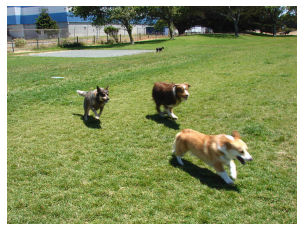

2
32
dogs are running on the grass beside the grass with two dogs in the background look behind them in the air as it is training the other chased behind them in the


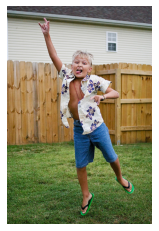

3
32
man in the red shirt is kicking soccer ball in its mouth and is chased by the other people look from the other in the middle of the woman in the orange


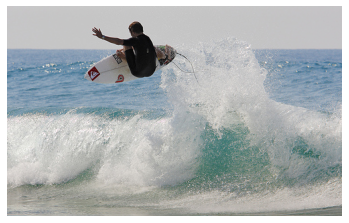

4
32
into the waves at the waters and the other others are in the air in the ocean and one is being pulled by the surfer in the black and white is on


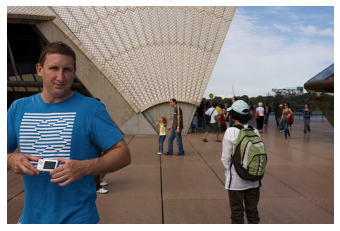

5
32
man in the red shirt is running in the street with his arms around her hand and another man in the background shirt and black shirt and black shorts is sitting on


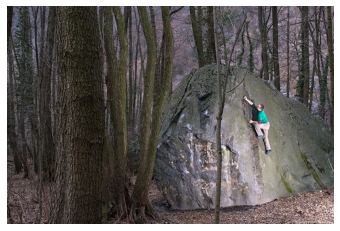

6
32
his bike on the side of the snowy with the sun and the sunlight in the background and the woman in the red shirt and no shirt is standing on the ledge


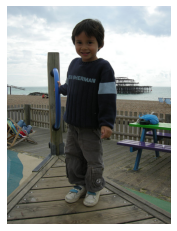

7
32
man in the red shirt is jumping on the sidewalk with his arms around the second of the woman in the background jacket and black shirt and black pants and black pants


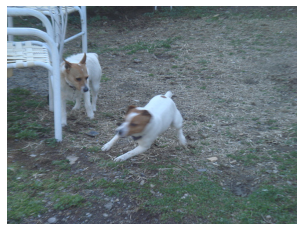

8
32
black dog is jumping over black and white dog in the yard with several other people follow behind them in the air to catch the ball in its mouth and one of


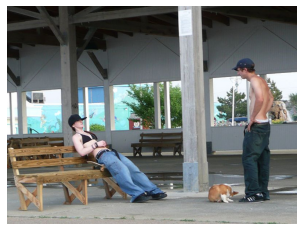

9
32
newspaper of man on bench and sitting on bench with his feet on the bench and black dog and black dog on the bench and black dog is training the other on


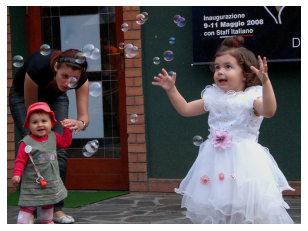

10
32
man in the red shirt is playing with the guitar on the floor of the bay and two other people look from the other on the ground and another man is holding


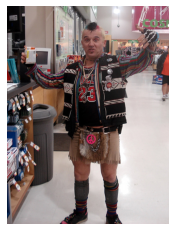

11
32
man in the red shirt is playing with the guitar in the air whilst others watch by the referee looks at the photographer in the orange shirt and white jersey and white


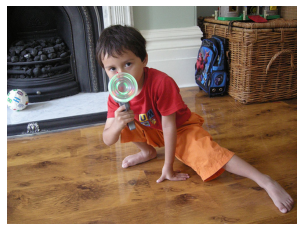

12
32
man in the red shirt is jumping on the grass with his tongue sticking out to the woman in the orange sweater is standing on the grass next to the woman who


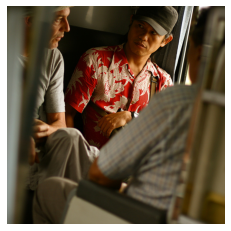

13
32
man in the red shirt is playing with his dog on the lap of the second of the driver in the orange shirt and black pants and red gloves and black shorts


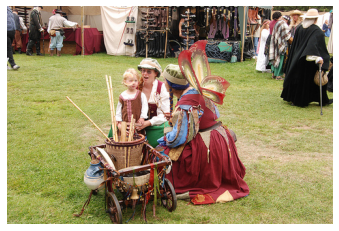

14
32
football players are tackling another player who is wearing white shirt and black shirt and black shirt and is in the middle of the man in the orange jersey is playing on


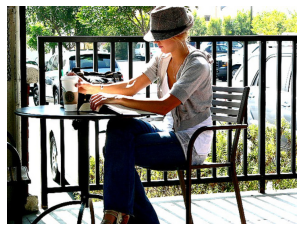

15
32
girl on the bench holding his arm around her on the phone and the woman in the black shirt and black pants is sitting on the concrete next to the man in


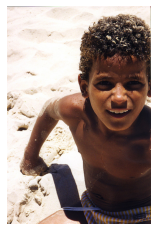

16
32
up the bottom of the snow with his head out of the ocean and the woman looks out of the frame of the sun and the woman in the orange shirt and


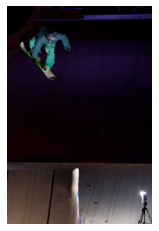

17
32
the red and white dog is jumping over red and white striped and white striped and training on the top of the red and white and white dog is jumping over the


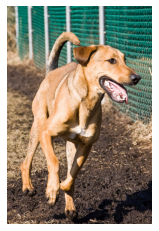

18
32
black and white dog is running on the grass with red toy in its mouth in the mouth and one of them is running through the grass with its tongue hanging in


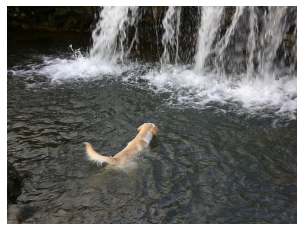

19
32
ball in the air above the edge of the ocean and slightly spraying from the mountains in the ocean and slightly tents in the air in the air and slightly tents in


In [92]:
k=0
for i in range(20):
    # koi bhi rnadom index b/w 0 to 1000
    rn = np.random.randint(0,1000)
    img_name = list(encoding_test.keys())[rn]
    # 1 is for batch and 2048 for image embedding
    photo = encoding_test[img_name].reshape((1,2048))
    # i is for path of the image images(folder) img_name(current image name)
    i = plt.imread(images+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    print(k)
    k+=1
    
#     print(i)
    caption = predict_caption(photo)
    print(len(caption.split()))
    print(caption)